@article{diode_dataset,
  title={{DIODE}: {A} {D}ense {I}ndoor and {O}utdoor {DE}pth {D}ataset},
  author={Igor Vasiljevic and Nick Kolkin and Shanyi Zhang and Ruotian Luo and
  Haochen Wang and Falcon Z. Dai and Andrea F. Daniele and Mohammadreza Mostajabi and
  Steven Basart and Matthew R. Walter and Gregory Shakhnarovich},
  journal={CoRR},
  volume={abs/1908.00463},
  year={2019},
  url={http ://arxiv.org/abs/1908.00463}
}

In [1]:
import os
import sys

import tensorflow as tf
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

tf.random.set_seed(24)

In [3]:
annotation_folder = "/data/"
if not os.path.exists(os.path.abspath(".") + annotation_folder):
    annotation_zip = tf.keras.utils.get_file(
        "val.tar.gz",
        cache_subdir=os.path.abspath("."),
        origin="http://diode-dataset.s3.amazonaws.com/val.tar.gz",
        extract=True,
    )

2774625282/2774625282 [==============================] - 67s 0us/step


In [4]:
path = '/content/val/outdoor'

In [12]:
paths = []
for root, dirs, files in os.walk(path):
    for file in files:
        paths.append(os.path.join(root, file))

In [14]:
paths = np.sort(paths)

In [15]:
len(paths)

1338

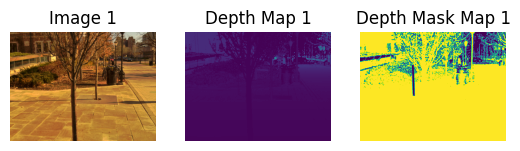

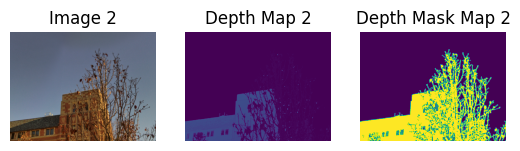

In [22]:
image_paths = ["/content/val/outdoor/scene_00022/scan_00194/00022_00194_outdoor_000_000.png", "/content/val/outdoor/scene_00022/scan_00194/00022_00194_outdoor_010_040.png"]  # Example image paths
depth_arrays = [np.load("/content/val/outdoor/scene_00022/scan_00194/00022_00194_outdoor_000_000_depth.npy"), np.load("/content/val/outdoor/scene_00022/scan_00194/00022_00194_outdoor_010_040_depth.npy")]  # Example depth arrays
depth_mask_arrays = [np.load("/content/val/outdoor/scene_00022/scan_00194/00022_00194_outdoor_000_000_depth_mask.npy"), np.load("/content/val/outdoor/scene_00022/scan_00194/00022_00194_outdoor_010_040_depth_mask.npy")]  # Example depth mask arrays

# Visualize the images and depth maps
for i in range(len(image_paths)):
    # Load the image
    image = plt.imread(image_paths[i])

    # Visualize the image
    plt.subplot(1, 3, 1)
    plt.title('Image {}'.format(i + 1))
    plt.imshow(image)
    plt.axis('off')

    # Visualize the depth map
    plt.subplot(1, 3, 2)
    plt.title('Depth Map {}'.format(i + 1))
    plt.imshow(depth_arrays[i], cmap='viridis')  # You can choose any colormap that suits your visualization
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Depth Mask Map {}'.format(i + 1))
    plt.imshow(depth_mask_arrays[i], cmap='viridis')  # You can choose any colormap that suits your visualization
    plt.axis('off')

    # Display the plots
    plt.show()


# in progress...